In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import random
import math

import matplotlib
from pylab import plot, legend, subplot, grid, xlabel, ylabel, show, title

from pyneurgen.neuralnet import NeuralNet
from pyneurgen.nodes import BiasNode, Connection

In [2]:
data_parque = pd.read_pickle('./data/cdsapi/Cerro_Saroche_cdsapi.pkl')
data_parque.head(4)

,latitude,longitude,id,elevation,Total precipitation,2 metre temperature,year_month,validDate,analDate
0,10.26,-69.88,0,520,0.000109,298.865784,198101,1981-01-01,1981-01-01
1,10.26,-69.88,0,520,0.001188,298.557373,198102,1981-02-01,1981-02-01
2,10.26,-69.88,0,520,0.000160,299.911194,198103,1981-03-01,1981-03-01
3,10.26,-69.88,0,520,0.006743,297.600708,198104,1981-04-01,1981-04-01


In [7]:
data_parque['month'] = data_parque['validDate'].dt.strftime("%m").apply(int)
data_parque['year'] = data_parque['validDate'].dt.strftime("%Y").apply(int)

In [9]:
def season(month,period = [11,12,1,2,3,4]):
    if month in period:
        return 'sequia'
    else:
        return 'lluvia'
        
data_parque['season'] = data_parque['month'].apply(season)

data_parque.head()

,latitude,longitude,id,elevation,Total precipitation,2 metre temperature,year_month,validDate,analDate,month,year,season
0,10.26,-69.88,0,520,0.000109,298.865784,198101,1981-01-01,1981-01-01,1,1981,sequia
1,10.26,-69.88,0,520,0.001188,298.557373,198102,1981-02-01,1981-02-01,2,1981,sequia
2,10.26,-69.88,0,520,0.000160,299.911194,198103,1981-03-01,1981-03-01,3,1981,sequia
3,10.26,-69.88,0,520,0.006743,297.600708,198104,1981-04-01,1981-04-01,4,1981,sequia
4,10.26,-69.88,0,520,0.004509,297.993896,198105,1981-05-01,1981-05-01,5,1981,lluvia


Tratamiento data sequia

In [11]:
def season_start(season,year,month,period=[11,12]):

    if season == 'lluvia':
        return year
    else:
        if month in period:
            return year
        else:
            return year-1

data_season = data_parque.copy()
data_season['start_season'] = data_season[['season','year','month']].apply(lambda x: season_start(x.season,x.year,x.month),1)
# date_season['start'] = date_season['month']
# date_season['end'] = date_season['month']
data_season= data_season\
                .groupby(['id','season','start_season'],as_index=False)\
                .agg({
                    # 'start':'min',
                    # 'end':'max',
                    'latitude':'max',
                    'longitude':'max',
                    'elevation':'max',
                    'Total precipitation':'mean',
                    '2 metre temperature':'mean'
                    })
data_season['t_precipitation'] = 100*data_season['Total precipitation'] 
data_season .head(5)

,id,season,start_season,latitude,longitude,elevation,Total precipitation,2 metre temperature,t_precipitation
0,0,lluvia,1981,10.26,-69.88,520,0.001863,299.222514,0.186284
1,0,lluvia,1982,10.26,-69.88,520,0.000715,299.647990,0.071504
2,0,lluvia,1983,10.26,-69.88,520,0.000939,300.143860,0.093895
3,0,lluvia,1984,10.26,-69.88,520,0.001103,299.530039,0.110301
4,0,lluvia,1985,10.26,-69.88,520,0.001930,299.213796,0.193001


In [12]:
import plotly.express as px

fig = px.line(data_season[(data_season.id==0)],
            x="start_season",
            y="Total precipitation",
            title='Estaciones',
            color='season',
            height=500,
            width=700)
fig.show()

Prueba de modelos

In [13]:
Y = data_season[(data_season.id==0) &
                (data_season.start_season>=1981) &
                (data_season.start_season<2020) &
                (data_season.season=='sequia') 
                ].sort_values('start_season')[['t_precipitation'#,'t_temperature'
               ]].to_numpy().reshape(-1, 1)


In [14]:
from pyneurgen.neuralnet import NeuralNet
from pyneurgen.recurrent import NARXRecurrent
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [15]:
####
# Ajustando modelo
#####

# data
all_inputs = Y[:-1]
all_targets = Y[1:]

# all_inputs = Y[:,1].reshape(-1, 1)
# all_targets = Y[1:,0].reshape(-1, 1)



# configuracion de la red
input_nodes = 1
hidden_nodes = 33#9
output_nodes = 1

output_order = 5#9
incoming_weight_from_output = .5
input_order = 5#39
incoming_weight_from_input = .5

net = NeuralNet()
net.init_layers(input_nodes, [hidden_nodes], output_nodes,
        NARXRecurrent(
            output_order,
            incoming_weight_from_output,
            input_order,
            incoming_weight_from_input))

net.randomize_network()

# fijando data
net.set_all_inputs(all_inputs) 
net.set_all_targets(all_targets)

#
# length = len(all_inputs)
# years_predict = 1

net.set_learn_range(0, int(len(Y))-2) 
net.set_test_range(0, int(len(Y)) -2) 

# funcion activacion
#net.layers[1].set_activation_type('sigmoid')
net.layers[1].set_activation_type('tanh')

In [16]:
net.learn(epochs=700, 
          show_epoch_results=False,
          random_testing=False)

mse = net.test()
print("test mse = ", mse)
 
test_positions = [item[0][0]/100 for item in net.get_test_data()]

all_targets1 = [item[0][0]/100 for item in net.test_targets_activations]
allactuals = [item[1][0]/100 for item in net.test_targets_activations]

test mse =  0.008120008589688065


Text(0.5, 1.0, 'Precipitación esperada vs precipitación actual')

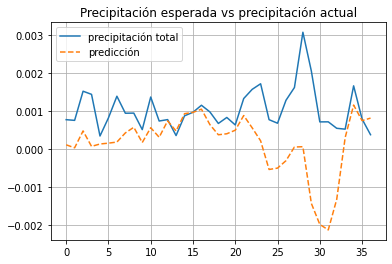

In [17]:
# subplot(2, 1, 1)
plot(all_targets1, '-', label='precipitación total')
plot(allactuals, '--', label='predicción')
grid(True)
legend(loc='upper left', numpoints=1)
title("Precipitación esperada vs precipitación actual")

Text(0.5, 1.0, 'Error cuadrático medio por epoca')

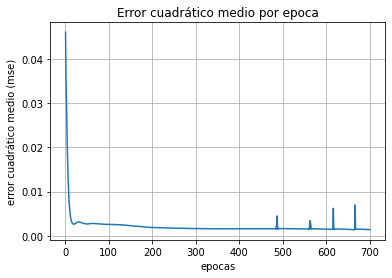

In [18]:
# subplot(2, 1, 2)
plot(range(1, len(net.accum_mse) + 1, 1), net.accum_mse)
xlabel('epocas')
ylabel('error cuadrático medio (mse)')
grid(True)
title("Error cuadrático medio por epoca")